#### (Stochastic Shared Embeddings - Personalized Transformer)
- SSE-PT

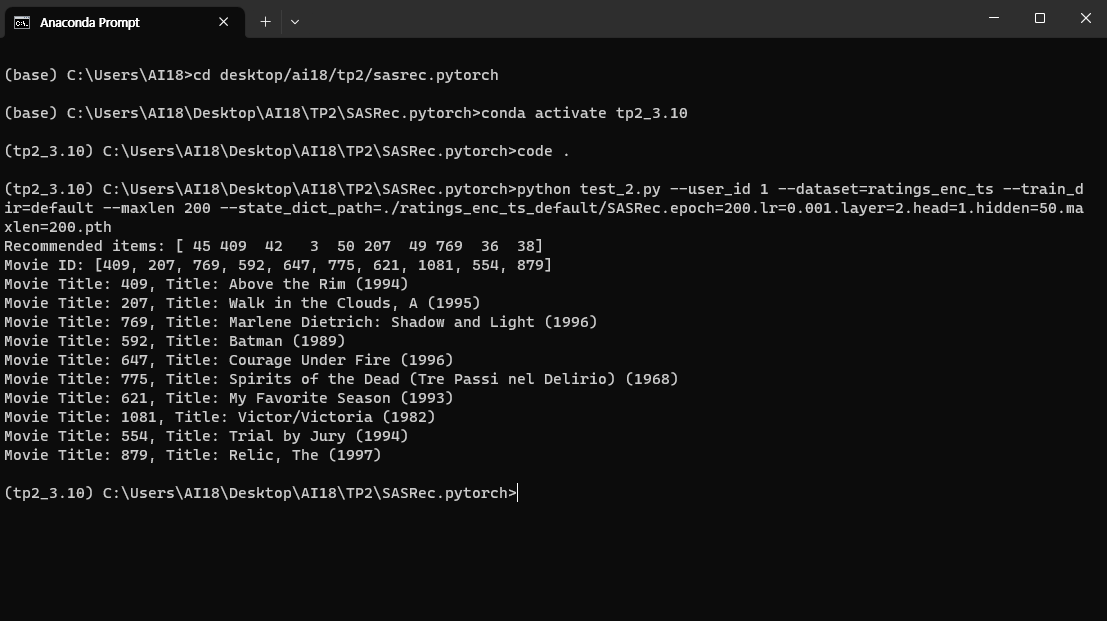

--dataset: 필수 인수입니다. 사용할 데이터셋의 이름을 지정합니다.<br>
<br>
--train_dir: 필수 인수입니다. 훈련 데이터가 위치한 디렉토리 경로를 지정합니다.<br>
<br>
--batch_size: 배치 크기를 설정합니다. 기본값은 128입니다.<br>
<br>
--lr: 학습률(learning rate)을 설정합니다. 기본값은 0.001입니다.<br>
<br>
--maxlen: 시퀀스나 문장의 최대 길이를 설정합니다. 기본값은 50입니다.<br>
<br>
--hidden_units: 은닉 유닛의 수를 설정합니다. 기본값은 50입니다.<br>
<br>
--num_blocks: 모델 내 블록(레이어)의 개수를 설정합니다. 기본값은 2입니다.<br>
<br>
--num_epochs: 훈련 에포크 수를 설정합니다. 기본값은 201입니다.<br>
<br>
--num_heads: 멀티헤드 어텐션에서의 어텐션 헤드 개수를 설정합니다. 기본값은 1입니다.<br>
<br>
--dropout_rate: 드롭아웃 비율을 설정합니다. 기본값은 0.5입니다.<br>
<br>
--l2_emb: 임베딩에 대한 L2 정규화 강도를 설정합니다. 기본값은 0.0입니다.<br>
<br>
--device: 디바이스를 설정합니다. 'cpu' 또는 'cuda'와 같은 값을 사용합니다. 기본값은 'cpu'입니다.<br>
<br>
--inference_only: 이 플래그를 제공하면, 사전 훈련된 모델을 사용하여 추론(테스트/예측)만 수행하고 훈련은 수행하지 않습니다.<br>
<br>
--state_dict_path: 사전 훈련된 모델의 상태 사전(state dictionary) 경로를 설정합니다.<br>

- SSE-PT에 사용된 ml-1m.txt 파일과 우리가 가지고있는 데이터가 조금 다르게 느껴져서 새롭게 라벨링함

In [1]:
import pandas as pd

# ratings.dat 파일을 읽습니다.
col_names = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_csv('../TP2/data/ratings.dat', sep='::', names=col_names, engine='python')

# 타임스탬프를 기준으로 데이터를 정렬합니다.
df = df.sort_values(by=['userId', 'timestamp'])
print(df)
# 사용자 ID와 영화 ID를 라벨 인코딩합니다.
user_encoder = {original: idx for idx, original in enumerate(df['userId'].unique(), start=1)}
movie_encoder = {original: idx for idx, original in enumerate(df['movieId'].unique(), start=1)}

df['userId'] = df['userId'].map(user_encoder)
df['movieId'] = df['movieId'].map(movie_encoder)

# .txt 파일로 저장합니다.
df[['userId', 'movieId']].to_csv('./data/ratings_SSE_PT.txt', sep=' ', index=False, header=False)
# df[['userId', 'movieId', 'rating', 'timestamp']].to_csv('./data/ratings_enc_ts_allcol.txt', sep=' ', index=False, header=False)
print(df)

         userId  movieId  rating  timestamp
31            1     3186       4  978300019
22            1     1270       5  978300055
27            1     1721       4  978300055
37            1     1022       5  978300055
24            1     2340       3  978300103
...         ...      ...     ...        ...
1000019    6040     2917       4  997454429
999988     6040     1921       4  997454464
1000172    6040     1784       3  997454464
1000167    6040      161       3  997454486
1000042    6040     1221       4  998315055

[1000209 rows x 4 columns]
         userId  movieId  rating  timestamp
31            1        1       4  978300019
22            1        2       5  978300055
27            1        3       4  978300055
37            1        4       5  978300055
24            1        5       3  978300103
...         ...      ...     ...        ...
1000019    6040     1249       4  997454429
999988     6040      371       4  997454464
1000172    6040       90       3  997454464
1000

In [48]:
import pandas as pd
import Dataloader

path = './data'
movies_df = Dataloader.load_movies(path)
movie_id_to_title = dict(zip(movies_df['movieId'], movies_df['title']))
movie_id_to_title

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (1995)',
 33: 'Wings of Courage (1995)',
 34: 'Babe (1

In [47]:
def load_encoders(file_path):
    """인코딩 했던 정보를 다시 가져오기 위한 함수"""
    df = pd.read_csv(file_path, sep=' ', header=None, names=['userId', 'movieId'])
    user_foward = {original: idx for idx, original in enumerate(df['userId'].unique(), start=1)}
    movie_foward = {original: idx for idx, original in enumerate(df['movieId'].unique(), start=1)}

    # decoder는 encoder의 반대입니다.
    user_back = {idx: original for original, idx in user_foward.items()}
    item_back = {idx: original for original, idx in movie_foward.items()}

    return user_back, item_back

In [45]:
import numpy as np

def recommend(model, user_seq, item_num, device='cpu'):
    user_seq = np.array(user_seq)
    user_seq = np.expand_dims(user_seq, 0)  # (1, seq_len)

    # 모든 영화에 대한 점수 예측
    item_indices = list(range(1, item_num + 1))
    scores = model.predict([0], user_seq, item_indices).squeeze(0)
    
    # 점수에 따라 영화 정렬
    recommended_items = scores.argsort(descending=True)[:10].cpu().numpy()

    return recommended_items

In [1]:
from util import data_partition
from util import *

dataset = data_partition('ml1m')

def get_user_seq(dataset, user_id):
    user_train, _, _, _, _ = dataset
    return user_train[user_id]

def pad_sequence(sequence, maxlen):
    padded_sequence = sequence[:maxlen] + [0] * (maxlen - len(sequence))
    return padded_sequence

maxlen = 200

user_seq = get_user_seq(dataset, 1)
user_seq_input = pad_sequence(user_seq, maxlen)  # 시퀀스 패딩
user_seq_input = np.expand_dims(user_seq_input, axis=0)  # 배치 차원 추가
user_seq_input.shape

(1, 200)

In [2]:
user_seq = get_user_seq(dataset, 1)
user_seq_input = pad_sequence(user_seq, maxlen)  # 시퀀스 패딩
user_seq_input = np.expand_dims(user_seq_input, axis=0)  # 배치 차원 추가
user_seq_input.shape

(1, 200)

In [4]:

usernum = 0
itemnum = 0
User = defaultdict(list)
user_train = {}
user_valid = {}
user_test = {}
# assume user/item index starting from 1
f = open('data/ml1m.txt', 'r')
for line in f:
    u, i = line.rstrip().split(' ')
    u = int(u)
    i = int(i)
    usernum = max(u, usernum)
    itemnum = max(i, itemnum)
    User[u].append(i)

for user in User:
    nfeedback = len(User[user])
    if nfeedback < 3:
        user_train[user] = User[user]
        user_valid[user] = []
        user_test[user] = []
    else:
        user_train[user] = User[user][:-2]
        user_valid[user] = []
        user_valid[user].append(User[user][-2])
        user_test[user] = []
        user_test[user].append(User[user][-1])
    # return [user_train, user_valid, user_test, usernum, itemnum]

In [5]:
user_train

{1: [32,
  23,
  28,
  38,
  25,
  37,
  4,
  8,
  48,
  1,
  22,
  45,
  10,
  52,
  44,
  42,
  49,
  19,
  12,
  15,
  43,
  18,
  40,
  46,
  27,
  3,
  7,
  20,
  39,
  53,
  2,
  14,
  50,
  51,
  16,
  21,
  47,
  6,
  9,
  13,
  29,
  24,
  11,
  17,
  30,
  34,
  41,
  5,
  31,
  36,
  33],
 2: [128,
  65,
  72,
  132,
  88,
  166,
  106,
  1,
  168,
  71,
  105,
  68,
  102,
  48,
  129,
  160,
  64,
  104,
  107,
  148,
  150,
  77,
  93,
  116,
  86,
  175,
  19,
  54,
  125,
  144,
  137,
  154,
  96,
  112,
  43,
  97,
  100,
  136,
  85,
  140,
  165,
  163,
  169,
  62,
  83,
  159,
  69,
  101,
  122,
  55,
  110,
  109,
  124,
  78,
  82,
  171,
  113,
  141,
  173,
  81,
  170,
  103,
  58,
  60,
  115,
  90,
  57,
  142,
  153,
  143,
  162,
  53,
  174,
  56,
  89,
  135,
  130,
  21,
  172,
  76,
  117,
  139,
  98,
  49,
  133,
  152,
  63,
  79,
  114,
  145,
  149,
  157,
  91,
  111,
  146,
  151,
  156,
  121,
  167,
  94,
  118,
  59,
  123,
  66,
  120,
  1

In [21]:
already_watched = set(user_seq)
len(already_watched)

51

In [13]:
item_idx_array = np.array(list(range(1, 101 + 1)))
# item_idx_array = np.expand_dims(item_idx_array, axis=0)
item_idx_array.shape

(101,)

In [19]:
all_item_indices = np.array(list(range(1, 3076 + 1)))
item_idx_array = np.tile(all_item_indices, (len(user_seq_input), 1))

In [21]:
item_idx_array.shape

(1, 3076)

In [3]:
import numpy as np

def pad_sequence(sequence, maxlen):
    padded_sequence = sequence[:maxlen] + [0] * (maxlen - len(sequence))
    return padded_sequence

# 사용 예시
user_seq = [1, 2, 3]
maxlen = 200
padded_seq = pad_sequence(user_seq, maxlen)
len(padded_seq)

200

#### loss값 저장해둔거 불러오기

In [22]:
import joblib

joblib.load('ml1m_first/loss_values.joblib')

[0.9242319,
 0.8376835,
 0.8166962,
 0.7964804,
 0.8119654,
 0.7699513,
 0.77337456,
 0.763187,
 0.7845049,
 0.7884192,
 0.77926964,
 0.7886896,
 0.77683836,
 0.75643736,
 0.7697358,
 0.75794077,
 0.7576954,
 0.74420804,
 0.76065373,
 0.74183047]